In [1]:
# Importing necessary packages 
import numpy as  np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import string

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.models import load_model

C:\Users\anilkrishna\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
true=pd.read_csv("True.csv")
fake=pd.read_csv("Fake.csv")

In [17]:
true.shape

(21417, 5)

In [18]:
fake.shape

(23481, 5)

In [19]:
true.head()

,title,text,subject,date,impression
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [20]:
fake.head()

,title,text,subject,date,impression
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [21]:
true.info

<bound method DataFrame.info of                                                    title  \
0      As U.S. budget fight looms, Republicans flip t...   
1      U.S. military to accept transgender recruits o...   
2      Senior U.S. Republican senator: 'Let Mr. Muell...   
3      FBI Russia probe helped by Australian diplomat...   
4      Trump wants Postal Service to charge 'much mor...   
...                                                  ...   
21412  'Fully committed' NATO backs new U.S. approach...   
21413  LexisNexis withdrew two products from Chinese ...   
21414  Minsk cultural hub becomes haven from authorities   
21415  Vatican upbeat on possibility of Pope Francis ...   
21416  Indonesia to buy $1.14 billion worth of Russia...   

                                                    text       subject  \
0      WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1      WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2      WASHINGTON (Reuter

In [22]:
fake.info

<bound method DataFrame.info of                                                    title  \
0       Donald Trump Sends Out Embarrassing New Year’...   
1       Drunk Bragging Trump Staffer Started Russian ...   
2       Sheriff David Clarke Becomes An Internet Joke...   
3       Trump Is So Obsessed He Even Has Obama’s Name...   
4       Pope Francis Just Called Out Donald Trump Dur...   
...                                                  ...   
23476  McPain: John McCain Furious That Iran Treated ...   
23477  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
23478  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
23479  How to Blow $700 Million: Al Jazeera America F...   
23480  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text      subject  \
0      Donald Trump just couldn t wish all Americans ...         News   
1      House Intelligence Committee Chairman Devin Nu...         News   
2      On Friday, it was rev

In [23]:
# Introducing new column in both dataframes

true['impression']=1
fake['impression']=0

In [24]:
# Concatenating them using pandas concatenate to form a single dataframe

data_raw = pd.concat([true, fake], axis=0)
data_raw.sample(10)

,title,text,subject,date,impression
12020,ARE ANGRY LEFTISTS Planning Violent Communist ...,Author Ed Klein told Pete Hegseth on Fox and F...,politics,"Jan 1, 2017",0
14707,PRICELESS: Watch Bill Clinton’s Awkward Respon...,Let s be honest when it comes to the Clinton c...,politics,"Jan 4, 2016",0
10189,WATCH: REMEMBER When President Clinton Took Cr...,Bill Clinton was falsely confident in his plan...,politics,"Aug 9, 2017",0
2104,Trump makes no decision on Afghanistan strategy,"HAGERSTOWN, Md./WASHINGTON (Reuters) - U.S. Pr...",politicsNews,"August 18, 2017",1
8723,U.S. officials working to restore public trust...,WASHINGTON (Reuters) - U.S. Attorney General L...,politicsNews,"July 18, 2016",1
3646,NC’s GOP-Run Board Of Elections Just Smacked ...,North Carolina governor Pat McCrory lost his r...,News,"November 29, 2016",0
18007,Brother of Marseille attacker arrested in Ital...,ROME (Reuters) - (This October 8 story has bee...,worldnews,"October 8, 2017",1
8298,Trump campaign criticizes Iran nuclear deal an...,WASHINGTON (Reuters) - U.S. Republican preside...,politicsNews,"September 1, 2016",1
416,Vegas Cops Take Cheap Shot At Michael Bennett...,Now that Seahawks star defensive end Michael B...,News,"September 7, 2017",0
13982,UNREAL! PRO-CUBA TRAVEL AT PBS AND NBC: “Cuba ...,BELOW ARE TWO EXAMPLES OF THE PRO-CUBA SENTIME...,politics,"May 5, 2016",0


In [25]:
# Combining title and text to obtain a single string
# dropping title and

data_raw['fulltext'] = data_raw.title + ' ' + data_raw.text
data_raw.drop(['title','text'], axis=1, inplace=True)

In [26]:
# Extracting a new dataframe using features fulltext and impression
data = data_raw[['fulltext', 'impression']]
data = data.reset_index()
data.drop(['index'], axis=1, inplace=True)

In [27]:
# Check for missing values

data.isnull().sum()

fulltext      0
impression    0
dtype: int64

In [28]:
print('The dataset contans {} rows and {} columns'.format(data.shape[0], data.shape[1]))

The dataset contans 44898 rows and 2 columns


In [29]:
data.head()

,fulltext,impression
0,"As U.S. budget fight looms, Republicans flip t...",1
1,U.S. military to accept transgender recruits o...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,1
3,FBI Russia probe helped by Australian diplomat...,1
4,Trump wants Postal Service to charge 'much mor...,1


In [30]:
# Word extraction from true and fake texts

true_text = data[data.impression==1]['fulltext']
fake_text = data[data.impression==0]['fulltext']
fake_text = fake_text.reset_index().drop(['index'], axis=1)

In [34]:
# Function to extract major words from true and fake news

def wordcloud_words(X_data_full):
    
    # function for removing punctuations
    def remove_punct(X_data_func):
        string1 = X_data_func.lower()
        translation_table = dict.fromkeys(map(ord, string.punctuation),' ')
        string2 = string1.translate(translation_table)
        return string2
    
    X_data_full_clear_punct = []
    for i in range(len(X_data_full)):
        test_data = remove_punct(X_data_full[i])
        X_data_full_clear_punct.append(test_data)
        
    # function to remove stopwords
    def remove_stopwords(X_data_func):
        pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
        string2 = pattern.sub(' ', X_data_func)
        return string2
    
    X_data_full_clear_stopwords = []
    for i in range(len(X_data_full)):
        test_data = remove_stopwords(X_data_full[i])
        X_data_full_clear_stopwords.append(test_data)
        
    # function for tokenizing
    def tokenize_words(X_data_func):
        words = nltk.word_tokenize(X_data_func)
        return words
    
    X_data_full_tokenized_words = []
    for i in range(len(X_data_full)):
        test_data = tokenize_words(X_data_full[i])
        X_data_full_tokenized_words.append(test_data)
        
    # function for lemmatizing
    lemmatizer = WordNetLemmatizer()
    def lemmatize_words(X_data_func):
        words = lemmatizer.lemmatize(X_data_func)
        return words
    
    X_data_full_lemmatized_words = []
    for i in range(len(X_data_full)):
        test_data = lemmatize_words(X_data_full[i])
        X_data_full_lemmatized_words.append(test_data)
        
    return X_data_full_lemmatized_words

In [26]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\anilkrishna\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\anilkrishna\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     C:\Users\anilkrishna\AppData\Roaming\nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to
[nltk_data]    |     C:\Users\anilkrishna\AppData\Roaming\nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to
[nltk_data]    |     C:\Users\anilkrishna\AppData\Roaming\nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to
[

[nltk_data]    | Downloading package ptb to
[nltk_data]    |     C:\Users\anilkrishna\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\ptb.zip.
[nltk_data]    | Downloading package product_reviews_1 to
[nltk_data]    |     C:\Users\anilkrishna\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\product_reviews_1.zip.
[nltk_data]    | Downloading package product_reviews_2 to
[nltk_data]    |     C:\Users\anilkrishna\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\product_reviews_2.zip.
[nltk_data]    | Downloading package pros_cons to
[nltk_data]    |     C:\Users\anilkrishna\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\pros_cons.zip.
[nltk_data]    | Downloading package qc to
[nltk_data]    |     C:\Users\anilkrishna\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\qc.zip.
[nltk_data]    | Downloading package reuters to
[nltk_data]    |     C:\Users\anilkrishna\AppData\Roaming\nltk_data...
[nltk_data

[nltk_data]    | Downloading package panlex_swadesh to
[nltk_data]    |     C:\Users\anilkrishna\AppData\Roaming\nltk_data...
[nltk_data]    | Downloading package mte_teip5 to
[nltk_data]    |     C:\Users\anilkrishna\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\mte_teip5.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\anilkrishna\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping taggers\averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\anilkrishna\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers\averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package perluniprops to
[nltk_data]    |     C:\Users\anilkrishna\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping misc\perluniprops.zip.
[nltk_data]    | Downloading package nonbreaking_prefixes to
[nltk_data]    |     

True

In [35]:
true_words = wordcloud_words(true_text)
fake_words = wordcloud_words(fake_text.fulltext)

In [36]:
def plot_wordcloud(text):
    wordcloud = WordCloud(background_color = 'black',
                         max_words = 3000,
                         width=1600,
                         height=800).generate(text)
    plt.clf()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

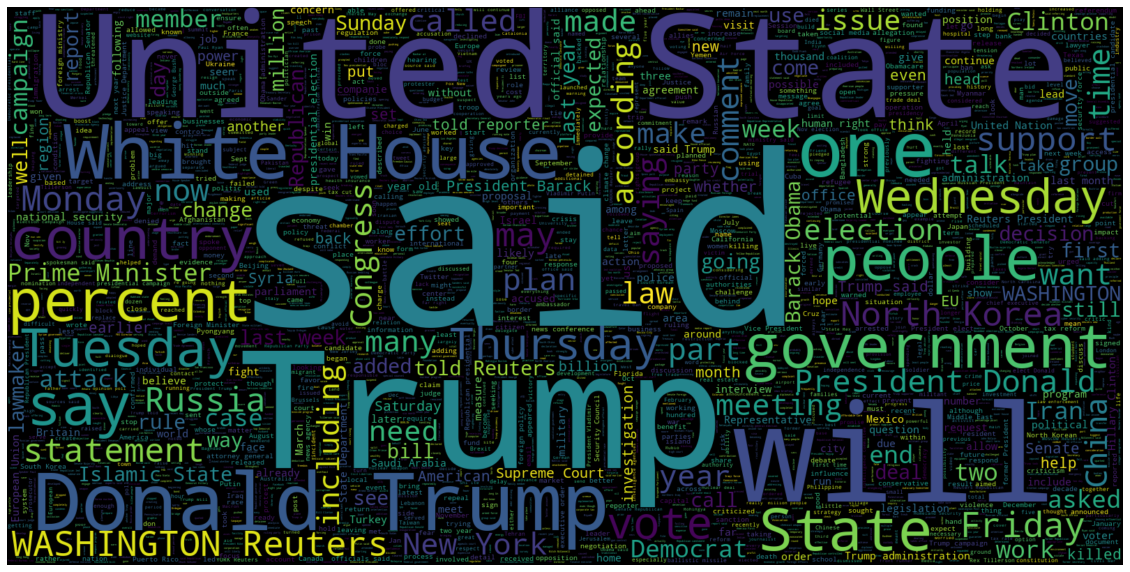

In [37]:
plt.figure(figsize=(20,18))
plot_wordcloud(' '.join(true_words))

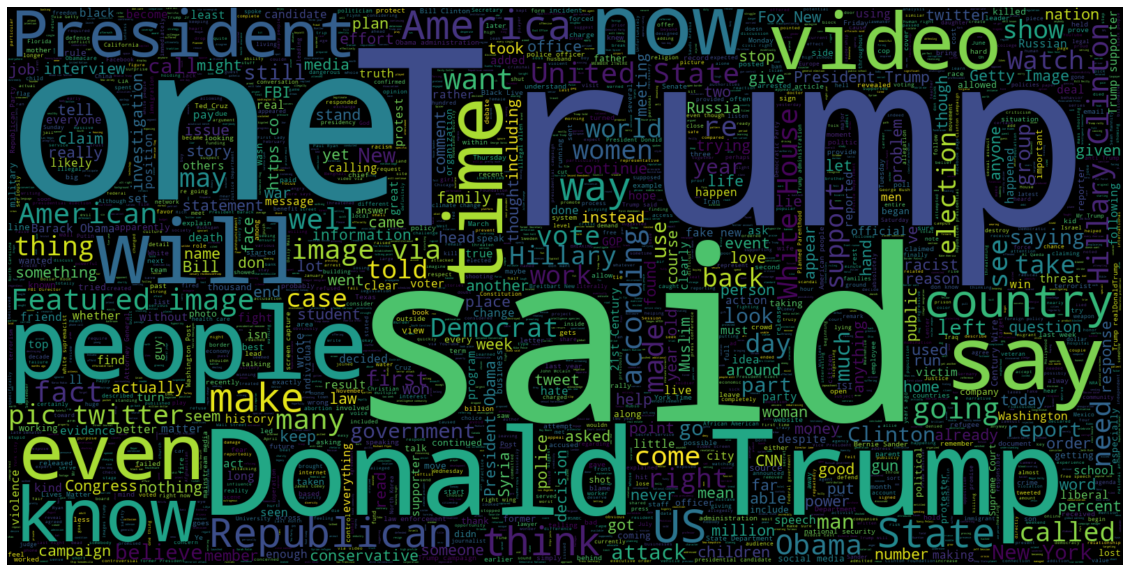

In [38]:
plt.figure(figsize=(20,18))
plot_wordcloud(' '.join(fake_words))

# ML Models 

In [39]:
# Data preparation

X_data = data['fulltext']
y_data = data.impression
X_data = X_data.astype(str)

In [40]:
X_data.head()

0    As U.S. budget fight looms, Republicans flip t...
1    U.S. military to accept transgender recruits o...
2    Senior U.S. Republican senator: 'Let Mr. Muell...
3    FBI Russia probe helped by Australian diplomat...
4    Trump wants Postal Service to charge 'much mor...
Name: fulltext, dtype: object

In [41]:
y_data.head()

0    1
1    1
2    1
3    1
4    1
Name: impression, dtype: int64

In [42]:
# Function to retrieve processed words

def final(X_data_full):
    
    # function for removing punctuations
    def remove_punct(X_data_func):
        string1 = X_data_func.lower()
        translation_table = dict.fromkeys(map(ord, string.punctuation),' ')
        string2 = string1.translate(translation_table)
        return string2
    
    X_data_full_clear_punct = []
    for i in range(len(X_data_full)):
        test_data = remove_punct(X_data_full[i])
        X_data_full_clear_punct.append(test_data)
        
    # function to remove stopwords
    def remove_stopwords(X_data_func):
        pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
        string2 = pattern.sub(' ', X_data_func)
        return string2
    
    X_data_full_clear_stopwords = []
    for i in range(len(X_data_full)):
        test_data = remove_stopwords(X_data_full[i])
        X_data_full_clear_stopwords.append(test_data)
        
    # function for tokenizing
    def tokenize_words(X_data_func):
        words = nltk.word_tokenize(X_data_func)
        return words
    
    X_data_full_tokenized_words = []
    for i in range(len(X_data_full)):
        test_data = tokenize_words(X_data_full[i])
        X_data_full_tokenized_words.append(test_data)
        
    # function for lemmatizing
    lemmatizer = WordNetLemmatizer()
    def lemmatize_words(X_data_func):
        words = lemmatizer.lemmatize(X_data_func)
        return words
    
    X_data_full_lemmatized_words = []
    for i in range(len(X_data_full)):
        test_data = lemmatize_words(X_data_full[i])
        X_data_full_lemmatized_words.append(test_data)
        
    # creating the bag of words model
    cv = CountVectorizer(max_features=1000)
    X_data_full_vector = cv.fit_transform(X_data_full_lemmatized_words).toarray()
    
    
    tfidf = TfidfTransformer()
    X_data_full_tfidf = tfidf.fit_transform(X_data_full_vector).toarray()
    
    return X_data_full_tfidf

In [43]:
# Setting the function with parameters

data_X = final(X_data)

In [51]:
# Preparing training and testing data using train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_X, y_data, test_size=0.25)

# Random Forest 

In [52]:
# Instatiation, fitting and prediction

rfc=RandomForestClassifier(n_estimators= 10)
rfc.fit(X_train, y_train)
predictions = rfc.predict(X_test)

In [53]:
# Model evaluation

print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

rfc_f1 = round(f1_score(y_test, predictions, average= 'weighted'), 3)
rfc_accuracy = round((accuracy_score(y_test, predictions) * 100), 2)

print("Accuracy : " , rfc_accuracy , " %")
print("f1_score : " , rfc_f1)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5808
           1       1.00      0.99      0.99      5417

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225

[[5793   15]
 [  78 5339]]
Accuracy :  99.17  %
f1_score :  0.992
